<a href="https://colab.research.google.com/github/MarkStephens060482/big_data_examples/blob/main/bootstrap_statistics_in_parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bootstrapped statistics and confidence intervals
### parallelism with PySpark

1. The distributions used in generating a population of random numbers are:
> A custom build approximate truncated skew normal distribution
> Normal distribution
> Skew Normal distribution
2. A PySpark implementation of bootstrapped statistics for large samples.
3. Bias-corrected and Accelerated (BCa) Confidence Intervals using SciPy.










In [ ]:
pip install pyspark

In [ ]:
"""
Truncated Skew Normal Random Number Generator
This uses a simpson method approximation for the integral of the pdf of the skew normal distribution
to form the cumulative distribution function.
Attributes:
    m - mean of distribution.
    s - standard deviation of distribution
    l - skew of distribution
    a - minimum value of truncated distribution
    b - maximum value of truncated distriubtion
    h - step size of numerical integration
"""
import numpy as np
from scipy import special
import math
# function to calculate the standard normal pdf
def znormpdf(x):
    return ((2*np.pi)**(-0.5))*np.exp(-0.5*(x**2))

# function to calculate the standard normal cdf
def znormcdf(x):
    return 0.5*(1 + special.erf(x/np.sqrt(2)))

# function for the skew normal pdf, using the standard normal pdf and standard normal cdf
def skewnormpdf(x,m,s,l):
    return (2/s)*znormpdf((x-m)/s)*znormcdf(l*(x-m)/s)

# function to calculate tyhe Simpson's rule approximation for the integral for cdf function, Integrating the skew normal pdf function.
def simpson_sncdf(x,m,s,l,h):
    # calculating the number of steps for step size of h to span from m-6*s to x
    n = int((x-(m-6*s))/h)
    array_prob = []
    array_z = []
    # find initial integration value and corresponding z_score
    integration = skewnormpdf(m-6*s,m,s,l)
    z_score = ((m-6*s)-m)/s
    array_prob.append(integration*h/3)
    array_z.append(z_score)
    # find all integration values at an interval of h apart with corresponding z_score.
    for i in range(1,n):
        k = (m-6*s) + i*h
        if i % 2 == 0:
            integration = integration + 2 * skewnormpdf(k,m,s,l)
        else:
            integration = integration + 4 * skewnormpdf(k,m,s,l)
        z_score = (k-m)/s
        array_prob.append(integration*h/3)
        array_z.append(z_score)
    # Finding final integration value and corresponding z_score
    integration = integration + skewnormpdf(x,m,s,l)
    z_score = (x-m)/s
    array_prob.append(integration*h/3)
    array_z.append(z_score)
    return array_z, array_prob

# function to calculate the approximate value for inverse cdf of truncated skew normal function. Approximation is based on Simpson's rule for cdf
def approx_inverse_sncdf(m,s,l,a,b,h):
    max_prob = simpson_sncdf(b,m,s,l,h)[1][-1]
    min_prob = simpson_sncdf(a,m,s,l,h)[1][-1]
    val = min_prob + np.random.uniform()*(max_prob-min_prob)
    arr = simpson_sncdf(1000,m,s,l,h)
    index = np.abs(arr[1] - val).argmin()
    return arr[0][index]

# function to generate the random number based on mean plus standard deviation  times approximation for inverse cdf of truncated skew normal.
def trucskewnormrand(m,s,l,a,b,h):
    rand_num = m + s*approx_inverse_sncdf(m,s,l,a,b,h)
    return rand_num


 ## Pseudo-Random number from Skewed Truncated Normal distribution

In [ ]:
m = 30 # mean
s = 7 # standard deviation
l = 2 # skew
a = 0 # minimum value
b = 50 # maximum value
h = 0.01 # step size for numerical approximation
trucskewnormrand(m,s,l,a,b,h)

31.78

### Bootstrapped Sample Statistics
1. Generate a population of size $N$.
2. Take a random sample of size $n$.
3. Performed $B$ bootstrapped samples and calculate statistics of each sample.
4. Observe distribution of bootstrapped statistics.

Perform in parallel with PySpark

In [ ]:
import numpy as np
import random as rd
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
from scipy.stats import bootstrap
from scipy.stats.mstats import trimmed_mean_ci, trimmed_mean
import matplotlib.pyplot as plt
import pandas as pd

# Create SparkSession and SparkContext
from pyspark.sql import SparkSession
from operator import add
from scipy.stats import skewnorm

spark = SparkSession.builder\
                  .master('local[*]')\
                  .appName('bootstrap')\
                  .getOrCreate()
sc = spark.sparkContext

# Random number generation functions
#Custom truncated skew normal distribution
def population_generation(B,N,m,s,l,a,b,h):
    return sc.parallelize(range(B)).map(lambda _: [trucskewnormrand(m,s,l,a,b,h) for _ in range(N)])
#Normal distribution
def population_generation1(B,N,m,s):
    return sc.parallelize(range(B)).map(lambda _: list(np.random.normal(m, s, N)))
#skew Normal distribution
def population_generation2(B,N,m,s,l):
    return sc.parallelize(range(B)).map(lambda _: list(skewnorm.rvs(l, loc=m, scale=s, size=N, random_state=123)))

# Function to generate a Random  sample
def generate_random_sample(data,n):
    return list(np.random.choice(data, size=n, replace=False))

# Function to generate bootstrap samples
def generate_bootstrap_sample(data):
    return np.random.choice(data, size=len(data), replace=True)

# Function to calculate mean and standard deviation
def calculate_stats(sample):
    return (float(np.mean(sample)), float(np.std(sample)))

# Parameters
N = 10000  # Population size
B = 5000 # Bootstraps
n = 500
##population parameters
m = 30
s = 7
l = 10
a = 0
b = 50
h = 0.01


# Generate random population in parallel
#population_rdd = population_generation(B,N,m,s,l,a,b,h)
#population_rdd = population_generation1(B,N,m,s)
population_rdd = population_generation2(B,N,m,s,l)
population_rdd.persist()

# Generate multiple samples in parallel
sample_rdd = population_rdd.map(lambda data: generate_random_sample(data,n))

# Generate Bootstraps samples in parallel
bootstraps_rdd = sample_rdd.map(lambda data: generate_bootstrap_sample(data))

#Calculate Statistics of bootstraps
boostrap_stats_rdd = bootstraps_rdd.map(lambda sample: calculate_stats(sample))

boostrap_stats_rdd.persist()
#Aggregate Statistics
aggregate_stats = boostrap_stats_rdd.reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]))

bootstrap_mean,bootstrap_stdev = np.round(aggregate_stats[0]/B,2), np.round(aggregate_stats[1]/B,2)
new_line = '\n'

print(f'The expected value of boostrapped sample means is:{bootstrap_mean}{new_line}\
The expected value of boostrapped sample standard deviation is: {bootstrap_stdev}')

def getParallelBootstrap(data, B):
  rdd = sc.parallelize(list(range(1, B+1)))
  rdd = rdd.map(lambda x: (x,) + getBootstrapedStats(data))
  return rdd

def getBootstrapedStats(data):
  number_points = len(data)
  sum_tally = 0
  sum_squared_tally = 0
  for inx in range(0,number_points):
    draw = data[rd.randint(0, number_points-1)]
    sum_tally += draw
    sum_squared_tally += draw**2
  return (float(sum_tally/number_points), float(((sum_squared_tally/number_points) - (sum_tally/number_points)**2)**0.5))


# Generate n random numbers from a normal distribution
#random_numbers_population = np.random.normal(m, s, N)

#random_sample = generate_random_sample(random_numbers_population,n)

#10,000 resamples:
#bootstrap_samples = getParallelBootstrap(random_sample, B)

# Define schema for DataFrame 1
schema1 = StructType([
    #StructField("Bootstrap", IntegerType(), True),
    StructField("Mean", FloatType(), True),
    StructField("Standard_deviation", FloatType(), True)])

sample = sample_rdd.first()

# Convert RDD to DataFrame using createDataFrame() with defined schema, convert to pandas df
df1 = spark.createDataFrame(boostrap_stats_rdd, schema1)
df2 = pd.DataFrame(sample,columns=["Random_sample"])

PATH = "/content/drive/MyDrive/Colab Notebooks/"
df1 = df1.toPandas()
df1.to_csv(PATH+'tsn_random_bootstrap_stats.csv')

df2.to_csv(PATH+'tsn_random_sample_data.csv')
# Stop SparkContext
#sc.stop()

The expected value of boostrapped sample means is:35.57
The expected value of boostrapped sample standard deviation is: 4.21


# Bootrap statistic distributions

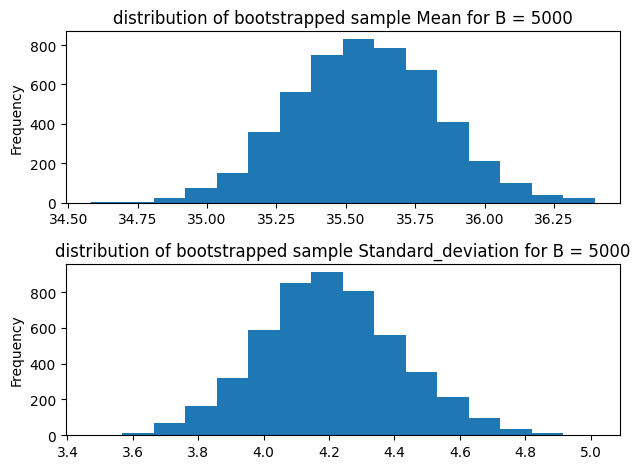

In [ ]:
fig, axes = plt.subplots(2, 1)

for i,col in enumerate(df1.columns):
  df1[col].plot(kind = "hist",
               bins = 16,
               title = f"distribution of bootstrapped sample {col} for B = {B}",
               ax = axes[i] )
plt.tight_layout()


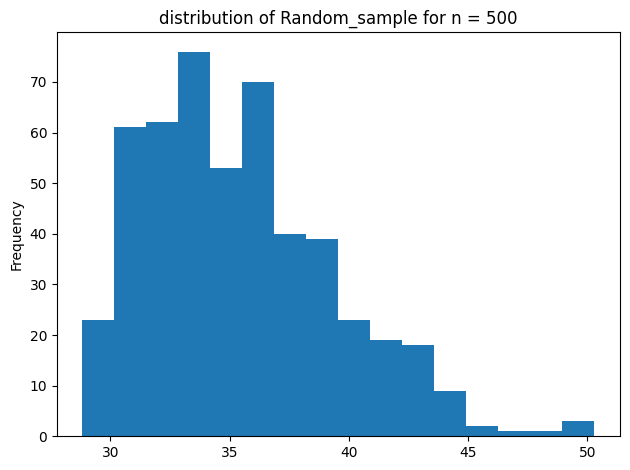

In [ ]:
fig, axes = plt.subplots(1, 1)

for i,col in enumerate(df2.columns):
  df2[col].plot(kind = "hist",
               bins = 16,
               title = f"distribution of {col} for n = {n}" )
plt.tight_layout()

#Bootstrapped Statistics with Confidence Intervals using SciPy
1. Comparing the percentile confidence intervals determined above to CI from SciPy bootstrap method

In [ ]:
data = (df2.Random_sample,)  # samples must be in a sequence
res = bootstrap(data,
          np.mean,
          n_resamples=9999,
          axis = 0,
          confidence_level=0.95,
          alternative='two-sided',
          method='BCa',
          random_state= 123)
res.confidence_interval

ConfidenceInterval(low=35.11547730882929, high=35.81292105943323)

In [ ]:
trimmed_mean_ci(data, limits=(0.1, 0.1), inclusive=(True, True), alpha=0.05, axis=None)

array([34.73965145, 35.47600393])